In [1]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from sbi.utils import BoxUniform
import torch

set_log_level(30)

/home/sam/miniconda3/envs/fenics-sbi-env/lib/python3.11/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/sam/miniconda3/envs/fenics-sbi-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
g = 9.81
R = 287.0
T_gas = 300.0
L = 10.0
N = 200
T= 5.0

mesh = IntervalMesh(N, 0, L)


dx_cell = L / N
CFL = 0.05

cell_centers = np.array([cell.midpoint().x() for cell in cells(mesh)])

def two_phase_simulator(theta, T=10.0, N=200, L=10.0, seed=None, return_full=False, include_sediment=False):
    """
    theta: [C_wall_L, C_wall_G, C_int, theta_incline, sediment_params]
    where sediment_params = [d_sed, rho_sed, C_sed_wall, C_sed_int] if include_sediment=True
    Returns:
        (timesteps+1, N) array of alpha_L, or optionally all fields.
    """
    # Unpack
    if include_sediment:
        C_wall_L, C_wall_G, C_int, theta_pipe, d_sed, rho_sed, C_sed_wall, C_sed_int = theta
    else:
        C_wall_L, C_wall_G, C_int, theta_pipe = theta

    rho_L = 800
    rho_G = 1.2

    if seed is not None:
        np.random.seed(seed)

    # Initial holdup and velocity profiles
    V = FunctionSpace(mesh, "DG", 0)
    x = SpatialCoordinate(mesh)
    alpha_L0 = project(0.5 + 0.15 * sin(2 * np.pi * x[0] / L), V)
    alpha_G0 = project(1.0 - (0.5 + 0.15 * sin(2 * np.pi * x[0] / L)), V)

    # Initialize sediment layer if included
    if include_sediment:
        h_sed0 = project(0.01 * sin(2 * np.pi * x[0] / L), V)  # Initial sediment layer
        h_sed_n = Function(V)
        h_sed_n.assign(h_sed0)
    else:
        h_sed_n = None

    u_L0 = 1.0 + .2 * np.sin(np.pi * cell_centers / L)
    u_G0 = 2.0 + .1 * np.cos(np.pi * cell_centers / L)

    dt = CFL * dx_cell / np.max([np.max(np.abs(u_L0)), np.max(np.abs(u_G0))])
    timesteps = int(T / dt)

    alpha_L_n = Function(V)
    alpha_G_n = Function(V)
    alpha_L_n.assign(alpha_L0)
    alpha_G_n.assign(alpha_G0)
    u_L_n = u_L0.copy()
    u_G_n = u_G0.copy()

    all_data_L = np.zeros((timesteps+1, V.dim()))
    all_data_G = np.zeros((timesteps+1, V.dim()))
    all_data_uL = np.zeros((timesteps+1, V.dim()))
    all_data_uG = np.zeros((timesteps+1, V.dim()))
    if include_sediment:
        all_data_sed = np.zeros((timesteps+1, V.dim()))
        all_data_sed[0, :] = h_sed_n.vector().get_local()
    all_data_L[0, :] = alpha_L_n.vector().get_local()
    all_data_G[0, :] = alpha_G_n.vector().get_local()
    all_data_uL[0, :] = u_L_n
    all_data_uG[0, :] = u_G_n

    def compute_geometries(alpha, h_sed=None):
        r = 0.05
        if h_sed is not None:
            r_eff = r - h_sed  # Effective radius considering sediment layer
        else:
            r_eff = r
            
        h_int = np.clip(r_eff * (2 * alpha - 1), -r_eff + 1e-8, r_eff - 1e-8)
        r2 = r_eff * r_eff
        root_h = np.sqrt(r2 - h_int**2)
        A_L = r2 * np.arccos(-h_int/r_eff) + h_int * root_h
        A_G = r2 * np.arccos(h_int/r_eff) - h_int * root_h
        P_LG = 2 * root_h
        P_LW = 2 * r_eff * np.arccos(-h_int/r_eff)
        P_GW = 2 * r_eff * np.arccos(h_int/r_eff)
        return h_int, A_L, A_G, P_LG, P_LW, P_GW

    for step in range(1, timesteps+1):
        alpha_L = alpha_L_n.vector().get_local()
        alpha_G = alpha_G_n.vector().get_local()
        u_L = u_L_n.copy()
        u_G = u_G_n.copy()
        
        if include_sediment:
            h_sed = h_sed_n.vector().get_local()
            h_int, A_L, A_G, P_LG, P_LW, P_GW = compute_geometries(alpha_L, h_sed)
        else:
            h_int, A_L, A_G, P_LG, P_LW, P_GW = compute_geometries(alpha_L)

        p_int = np.full_like(alpha_L, rho_G * R * T_gas)
        # Hydrostatic pressure (linear)
        p_av_L = p_int + rho_L * g * (h_int) * np.sin(theta_pipe)
        p_av_G = p_int + rho_G * g * (h_int) * np.sin(theta_pipe)
        
        # Pressure gradients
        p_grad_L = np.zeros_like(p_av_L)
        p_grad_G = np.zeros_like(p_av_G)
        p_grad_L[1:-1] = (p_av_L[2:] - p_av_L[:-2]) / (2 * dx_cell)
        p_grad_G[1:-1] = (p_av_G[2:] - p_av_G[:-2]) / (2 * dx_cell)
        p_grad_L[0] = (p_av_L[1] - p_av_L[0]) / dx_cell
        p_grad_L[-1] = (p_av_L[-1] - p_av_L[-2]) / dx_cell
        p_grad_G[0] = (p_av_G[1] - p_av_G[0]) / dx_cell
        p_grad_G[-1] = (p_av_G[-1] - p_av_G[-2]) / dx_cell

        # --- ADVECT HOLDUPS (Upwind FV) ---
        F_L = np.zeros_like(alpha_L)
        F_L[1:] = A_L[1:] * u_L[1:] * alpha_L[1:]
        F_L[0]  = A_L[0]  * u_L[0]  * alpha_L[0]
        F_L_left = np.zeros_like(alpha_L)
        F_L_left[1:] = A_L[:-1] * u_L[:-1] * alpha_L[:-1]
        F_L_left[0]  = A_L[0]  * u_L[0]  * alpha_L[0]
        alpha_L_new = alpha_L - dt/dx_cell * (F_L - F_L_left) / (A_L + 1e-12)

        F_G = np.zeros_like(alpha_G)
        F_G[1:] = A_G[1:] * u_G[1:] * alpha_G[1:]
        F_G[0]  = A_G[0]  * u_G[0]  * alpha_G[0]
        F_G_left = np.zeros_like(alpha_G)
        F_G_left[1:] = A_G[:-1] * u_G[:-1] * alpha_G[:-1]
        F_G_left[0]  = A_G[0]  * u_G[0]  * alpha_G[0]
        alpha_G_new = alpha_G - dt/dx_cell * (F_G - F_G_left) / (A_G + 1e-12)

        # --- MOMENTUM (Upwind FV + drag + pressure/grav) ---
        m_L = alpha_L * rho_L * u_L
        Fm_L = np.zeros_like(m_L)
        Fm_L[1:] = A_L[1:] * (u_L[1:]**2) * alpha_L[1:] * rho_L
        Fm_L[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0] * rho_L
        Fm_L_left = np.zeros_like(m_L)
        Fm_L_left[1:] = A_L[:-1] * (u_L[:-1]**2) * alpha_L[:-1] * rho_L
        Fm_L_left[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0] * rho_L
        
        gravity_L = A_L * rho_L * g * np.sin(theta_pipe)
        
        # Modified wall friction to account for sediment
        if include_sediment:
            C_wall_L_eff = C_wall_L + C_sed_wall * h_sed
            C_int_eff = C_int + C_sed_int * h_sed
        else:
            C_wall_L_eff = C_wall_L
            C_int_eff = C_int
            
        m_L_new = m_L \
                  - dt/dx_cell * (Fm_L - Fm_L_left) / (A_L + 1e-12) \
                  - dt * C_wall_L_eff * m_L \
                  + dt * C_int_eff * alpha_L * rho_L * (u_G - u_L) \
                  - dt * A_L * p_grad_L \
                  + dt * gravity_L
                  
        u_L_new = np.where(alpha_L_new > 1e-12, m_L_new / (alpha_L_new * rho_L + 1e-12), 0.0)

        m_G = alpha_G * rho_G * u_G
        Fm_G = np.zeros_like(m_G)
        Fm_G[1:] = A_G[1:] * (u_G[1:]**2) * alpha_G[1:] * rho_G
        Fm_G[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0] * rho_G
        Fm_G_left = np.zeros_like(m_G)
        Fm_G_left[1:] = A_G[:-1] * (u_G[:-1]**2) * alpha_G[:-1] * rho_G
        Fm_G_left[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0] * rho_G

        gravity_G = A_G * rho_G * g * np.sin(theta_pipe)

        # Modified wall friction to account for sediment
        if include_sediment:
            C_wall_G_eff = C_wall_G + C_sed_wall * h_sed
        else:
            C_wall_G_eff = C_wall_G

        m_G_new = m_G \
                  - dt/dx_cell * (Fm_G - Fm_G_left) / (A_G + 1e-12) \
                  - dt * C_wall_G_eff * m_G \
                  - dt * C_int_eff * alpha_G * rho_G * (u_G - u_L) \
                  - dt * A_G * p_grad_G \
                  + dt * gravity_G

        u_G_new = np.where(alpha_G_new > 1e-12, m_G_new / (alpha_G_new * rho_G + 1e-12), 0.0)

        # --- SEDIMENT TRANSPORT (if included) ---
        if include_sediment:
            # Simple sediment transport model
            # Deposition rate proportional to velocity and sediment concentration
            # Erosion rate proportional to shear stress
            tau_wall = 0.5 * rho_L * u_L**2  # Wall shear stress
            tau_crit = 0.1  # Critical shear stress for erosion
            
            # Deposition and erosion rates
            dep_rate = 0.01 * u_L * (1 - h_sed/0.05)  # Deposition rate
            ero_rate = 0.02 * (tau_wall - tau_crit) * (tau_wall > tau_crit)  # Erosion rate
            
            # Update sediment layer
            h_sed_new = h_sed + dt * (dep_rate - ero_rate)
            h_sed_new = np.clip(h_sed_new, 0, 0.05)  # Limit sediment layer thickness
            
            h_sed_n.vector().set_local(h_sed_new)
            all_data_sed[step, :] = h_sed_new

        # --- ENFORCE CLOSURE ---
        sum_holdup = alpha_L_new + alpha_G_new
        alpha_L_new /= (sum_holdup + 1e-12)
        alpha_G_new /= (sum_holdup + 1e-12)

        # Save and update
        alpha_L_n.vector().set_local(alpha_L_new)
        alpha_G_n.vector().set_local(alpha_G_new)
        u_L_n = u_L_new
        u_G_n = u_G_new
        all_data_L[step, :] = alpha_L_new
        all_data_G[step, :] = alpha_G_new
        all_data_uL[step, :] = u_L_new
        all_data_uG[step, :] = u_G_new

    if return_full:
        if include_sediment:
            return all_data_L, all_data_G, all_data_uL, all_data_uG, all_data_sed, timesteps
        else:
            return all_data_L, all_data_G, all_data_uL, all_data_uG, timesteps
    else:
        return all_data_L, timesteps

In [8]:
example_theta = [0.005, 0.003, 0.01, 0.4, 0.001, 2650.0, 0.1, 0.05]
results = two_phase_simulator(example_theta,T=50, include_sediment=True, return_full=True)

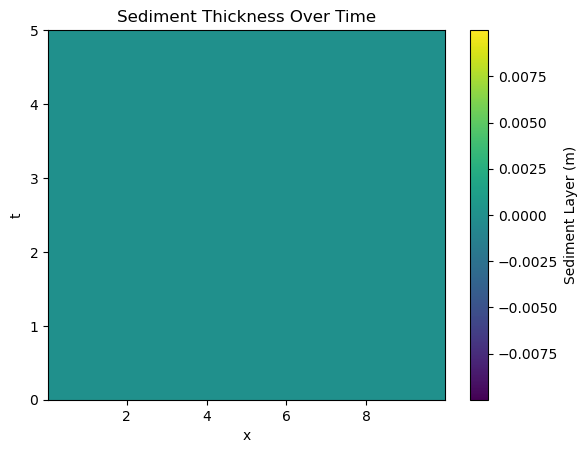

In [9]:

plt.imshow(results[4], aspect='auto', origin='lower', 
           extent=[cell_centers[0], cell_centers[-1], 0, T])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Sediment Thickness Over Time')
plt.colorbar(label='Sediment Layer (m)')
plt.show()